# 数据访问对象

In [1]:
import base64
import configparser
import pymysql

## 连接数据库

In [2]:
# cursor.description 字段
class ConnectDB(object):
    def __init__(self, db_config, db_driver):
        try:
            # print("Connect to: " + db_config)
            self.cfp = configparser.ConfigParser()
            self.cfp.read("config.ini")

            ip = self.cfp.get(db_config, "ip")
            user_name = self.cfp.get(db_config, "user_name")
            psd = str(base64.b64decode(bytes(self.cfp.get(db_config, "psd"), encoding='utf-8')), encoding='UTF-8')
            db_name = self.cfp.get(db_config, "db_name")
            self.conn = db_driver.connect(ip, user_name, psd, db_name)
            self.cursor = self.conn.cursor()
        except Exception as e:
            print(e)

    def close(self):
        self.conn.close()

## 天气接口

In [3]:
class WeatherDao(ConnectDB):
    def __init__(self):
        super().__init__("db3", pymysql)

    def close(self):
        super().close()

    def get(self, year, month, day):
        try:
            sql = "select * from weather where year = {year} and month = {month} and day = {day}" \
                .format(year=year, month=month, day=day)
            self.cursor.execute(sql)
            result = self.cursor.fetchall()
            return result if (result is not None) else None
        except Exception as e:
            print(e)

In [4]:
weather = WeatherDao()
result = weather.get(2020, 5, 1)
print(result[0][4:9])

(26, 20, '小雨~中雨', '东南风', '2级')


## 假日接口

In [5]:
class DateTypeDao(ConnectDB):

    def __init__(self):
        super().__init__("db3", pymysql)

    def close(self):
        super().close()

    def get(self, year, month, day):
        try:
            sql = "select * from holiday where year={year} and month={month} and day={day}" \
                .format(year=year, month=month, day=day)
            self.cursor.execute(sql)
            result = self.cursor.fetchone()
            return result if (result is not None) else None
        except Exception as e:
            print(e)

In [6]:
date_type = DateTypeDao()
result = date_type.get(2020, 1, 25)
print(result[-1])

2


## 供水量接口

In [7]:
class WaterSupplyDao(ConnectDB):
    def __init__(self):
        super().__init__("db4", pymysql)

    def close(self):
        super().close()

    def get(self, date):
        try:
            sql = "SELECT now_datetime as `date`, now_daily_water_flow as `output` FROM " \
                "`auto_report_3` where area_id = 2 and now_datetime = '{date}'" \
                " order by now_datetime;".format(date=date)
            self.cursor.execute(sql)
            result = self.cursor.fetchone()
            return result if (result is not None) else None
        except Exception as e:
            print(e)

In [8]:
water_supply = WaterSupplyDao()
result = water_supply.get("2018-12-30")
print(result)

None


# 原始数据收集

In [9]:
import datetime as dt
import pandas as pd
from sklearn.model_selection import train_test_split

## 导入供水量 csv

In [10]:
data_frame = pd.read_csv("water_supply.csv")

In [11]:
data_frame

,日期,供水量
0,2019/6/1,30.24
1,2019/6/2,32.84
2,2019/6/3,33.64
3,2019/6/4,33.84
4,2019/6/5,33.64
...,...,...
361,2020/5/27,33.48
362,2020/5/28,33.36
363,2020/5/29,30.71
364,2020/5/30,29.93


## 添加天气和假日

In [12]:
weather = WeatherDao()
datetype = DateTypeDao()
weather_list = list()
datetype_list = list()
for index, row in data_frame.iterrows():
    date = dt.datetime.strptime(row["日期"], "%Y/%m/%d")

    w = weather.get(date.year, date.month, date.day)
    d = datetype.get(date.year, date.month, date.day)
    weather_list.append(w[0][4:9])
    datetype_list.append(d[-1])

weather.close()
datetype.close()

In [13]:
weather_data_frame = pd.DataFrame(weather_list, columns=["最高温", "最低温", "天气", "风向", "风力"])
# 丢弃风向
weather_data_frame = weather_data_frame.drop(columns=["风向"])
# 替换风力
replace_dict = {"1级": 5, "2级": 4, "3级": 3, "4级": 2, "5级": 1}
weather_data_frame = weather_data_frame.replace(replace_dict)
# 天气独热编码
weather_data_frame = pd.get_dummies(weather_data_frame, columns=['天气'])

In [14]:
datetype_data_frame = pd.DataFrame(datetype_list, columns=["日期类型"])
# 日期类型独热编码
datetype_data_frame = pd.get_dummies(datetype_data_frame, columns=["日期类型"])

In [15]:
X_data_frame = pd.concat([weather_data_frame, datetype_data_frame], axis=1)
X_data_frame

,最高温,最低温,风力,天气_中雨,天气_中雨~多云,天气_中雨~大雨,天气_中雨~小雨,天气_中雨~阴,天气_多云,天气_多云~中雨,...,天气_雷阵雨~大雨,天气_雷阵雨~小雨,天气_雷阵雨~阴,天气_雷阵雨~阵雨,天气_雾~多云,天气_雾~小雨,日期类型_0,日期类型_1,日期类型_2,日期类型_3
0,27,19,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,28,21,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,31,20,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,33,22,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,34,25,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,30,20,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
362,31,21,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
363,25,19,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
364,22,18,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
Y_data_frame = data_frame.drop(columns=['日期'])
Y_data_frame

,供水量
0,30.24
1,32.84
2,33.64
3,33.84
4,33.64
...,...
361,33.48
362,33.36
363,30.71
364,29.93


In [79]:
x_data = X_data_frame.to_numpy().squeeze().astype('float32')
y_data = Y_data_frame.to_numpy().squeeze().astype('float32')

# x_data[:,0] = (x_data[:,0] - x_data[:,0].mean()) / x_data[:,0].std()
# x_data[:,1] = (x_data[:,1] - x_data[:,1].mean()) / x_data[:,1].std()
# x_data[:,2] = (x_data[:,2] - x_data[:,2].mean()) / x_data[:,2].std()
# y_data = (y_data - y_data.mean()) / y_data.std()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4)

In [80]:
print(x_train)
print(y_train)

[[29. 22.  3. ...  0.  0.  0.]
 [28. 23.  4. ...  0.  0.  0.]
 [23. 17.  4. ...  0.  0.  1.]
 ...
 [11.  6.  4. ...  0.  0.  1.]
 [38. 30.  4. ...  0.  0.  0.]
 [12.  6.  2. ...  0.  0.  0.]]
[35.93 33.9  34.36 32.21 33.42 31.29 32.95 34.51 32.53 21.73 33.85 31.16
 33.51 29.1  33.63 31.44 34.53 32.66 33.17 35.94 36.6  32.42 30.66 32.93
 34.8  33.22 34.15 27.97 29.93 28.42 32.1  31.55 28.18 35.36 34.49 35.67
 29.65 30.65 35.78 30.35 21.07 36.1  33.81 26.82 34.04 34.4  34.36 32.54
 31.15 30.62 34.37 34.56 35.82 31.5  33.39 29.91 33.56 32.63 36.65 30.45
 35.07 34.15 35.94 30.07 28.06 36.22 32.72 30.54 32.74 30.09 33.81 31.43
 31.24 37.35 35.1  32.5  35.13 30.53 22.23 33.15 21.   31.34 29.93 33.22
 26.3  21.23 30.93 33.36 23.43 28.36 25.53 35.46 29.59 31.16 32.65 36.51
 37.81 33.56 27.23 36.82 28.91 33.84 24.61 32.67 29.68 30.95 33.45 33.78
 35.33 32.6  23.69 37.15 32.95 34.68 35.36 32.54 37.58 31.32 29.83 30.74
 32.08 34.65 35.64 29.38 20.18 21.62 33.19 35.9  22.92 33.57 33.09 24.45
 30.9

# 构建模型

In [92]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input, Model, layers, optimizers, losses, metrics, datasets

In [87]:
network = Sequential([
    layers.Dense(units=64, activation='relu', input_shape=(54,)),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(),
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(),
    layers.Dense(units=1, activation=None)
])

In [99]:
network.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [100]:
# 显示网络结构信息
network.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                3520      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_37 (Dense)             (None, 64)               

In [101]:
# 执行训练与验证
history = network.fit(x_train, y_train, epochs = 500, batch_size=10, validation_split=0.2)

se: 9.8507
Epoch 352/500
18/18 [==============================] - 0s 5ms/step - loss: 9.4921 - mse: 9.4106 - val_loss: 9.2688 - val_mse: 9.8829
Epoch 353/500
18/18 [==============================] - 0s 4ms/step - loss: 9.2031 - mse: 9.4212 - val_loss: 9.1949 - val_mse: 9.6603
Epoch 354/500
18/18 [==============================] - 0s 4ms/step - loss: 10.6258 - mse: 10.7291 - val_loss: 9.1902 - val_mse: 9.4762
Epoch 355/500
18/18 [==============================] - 0s 5ms/step - loss: 8.5714 - mse: 8.5750 - val_loss: 9.3041 - val_mse: 9.7044
Epoch 356/500
18/18 [==============================] - 0s 4ms/step - loss: 9.1954 - mse: 9.1830 - val_loss: 9.9965 - val_mse: 10.7751
Epoch 357/500
18/18 [==============================] - 0s 5ms/step - loss: 8.7468 - mse: 8.9023 - val_loss: 9.6426 - val_mse: 10.4405
Epoch 358/500
18/18 [==============================] - 0s 5ms/step - loss: 8.4695 - mse: 8.5574 - val_loss: 9.5269 - val_mse: 10.2207
Epoch 359/500
18/18 [==============================] 

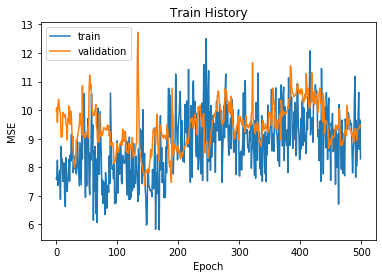

In [102]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title("Train History")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(['train','validation'])
plt.show()

# 可视化

In [110]:
pred = network.predict(x_test)
true = y_test

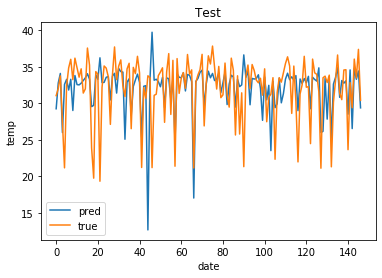

In [111]:
plt.plot(pred)
plt.plot(true)
plt.title("Test")
plt.ylabel("temp")
plt.xlabel("date")
plt.legend(['pred','true'])
plt.show()